# winter 2022 week03

## goals:

reload the data
run util/load_data.py convert_all() function -- which loads everything and converts it to parquet

## todo
- ~add PIPA to list of interesting ones (57 -> 58)~
- ~figure out how to get the thing to run faster (try to just use geopoints_sampled in analyze)~
- ~final count of reduced fishing~
- run the analyze thing over those 7/8
- make those charts of in/out fishing effort of individual ships for those 7/8
- make pictures of before/after fishing effort of individual ships for those 7/8 (could use consistent colors)

THEN:
- ~make ~table~ scatter-plot of (low, low), (low, high), (high, low), (high, high). etc. of the 171~
- ~make table of (?, low), (?, high) of all the other ones~
- try to categorize the mpas (sum up area and #, etc.)

AND THEN:
- compare to the paper about 5 MPAs
- email Dan to show him everything
- title: what can GFW data tell us about the true protection of MPA?
- two effective scenarios: (high, low) and (low, low) ~= (?, low)


## notes:



In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
cd /Users/brendan/Documents/mpa_project/gfw_research

/Users/brendan/Documents/mpa_project/gfw_research


In [5]:
import numpy as np
import pandas
from datetime import datetime
import matplotlib.pyplot as plt
import os
import pywdpa
import geopandas
import contextily as ctx
from shapely import geometry
from shapely import ops
import pretty_html_table
import cProfile

import util

pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_rows', None)

/opt/homebrew/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [6]:
DATA_PATH = "/Users/brendan/Documents/mpa_project/gfw_research/data/"
FILENAME = "mpatlas_20201223_clean/mpatlas_20201223_clean.shp"

#mpas = geopandas.read_file(DATA_PATH + FILENAME)
# util.load_mpatlas_mpas()
mpas = geopandas.read_parquet("data/mpas/mpatlas.parquet")

In [7]:
def load_year(year):
    year = str(year)
    print(f'\r reading year {year}', end='')
    return pandas.read_parquet("data/points/" + year + ".parquet")

In [8]:
points_by_year = {
    year : load_year(year)
    for year in range(2012, 2021)
}

 reading year 2020

In [9]:
# sample the points here before converting to geo
# use the sampled points to find the mmsi that are interesting
# only then should we get all of the points of relevent mmsi

SAMPLE_RATIO = 100
points_sampled = []
for year, points in points_by_year.items():
    print(f'\rsampling {str(year)}... ', end='')
    points_sampled.append(points.sample(frac=1/SAMPLE_RATIO))
print('done.')
points_sampled = pandas.concat(points_sampled)
print("converting to geo...  ", end='')
geopoints_sampled = util.convert_to_geo(points_sampled, box=True)
print("done.")


sampling 2020... done.
converting to geo...  done.


In [11]:
no_take = mpas[(mpas['no_take']=='All') & (mpas['implemente'])]
of_interest_frame = no_take[
    ((no_take['status_yea'] >= 2012) | (no_take['implementa'] > '2012-01-01')) & no_take['implemente']]
of_interest = [
    (None, 555512002, 'Phoenix Island Protected Area', '2015-01-01')
]
# for i, row in no_take[no_take['status_yea'] > 2012].iterrows():
for i, row in of_interest_frame.iterrows():
    date = row['implementa']
    if date is None:
        date = str(row['status_yea'])
    of_interest.append(
        (row['mpa_id'], row['wdpa_id'], row['name'], date)
    )

# np.random.shuffle(of_interest)

In [12]:
import util

tables = pandas.DataFrame()
summed_tables = pandas.DataFrame()
j = 0
for mpa_id, wdpa_id, name, date in of_interest:
    j += 1
    print(f'\r{j}/{len(of_interest)} {mpa_id} {wdpa_id} {name} {date}                           ', end='')
    mpa = None
    if wdpa_id:
        mpa = mpas[mpas['wdpa_id'] == wdpa_id].dissolve(by='wdpa_id')
    elif mpa_id:
        mpa = mpas[mpas['mpa_id'] == mpa_id].dissolve(by='mpa_id')
    else:
        print(f'no id for {name}, skipping')
        continue
    
    returned = util.analyze_mpa(geopoints_sampled, points_by_year, mpa, date, verbose=False, plot_pre_post=False)
    if returned is not None:
        table = returned
        table.insert(0, 'name', name)
        table.insert(1, 'date', date)
        table.insert(2, 'wdpa_id', wdpa_id)
        table.insert(3, 'mpa_id', mpa_id)
        tables = tables.append(table)
        
        summed = table.groupby('name').aggregate({
            'name': 'first',
            'wdpa_id': 'first',
            'mpa_id': 'first',
            'date': 'first',
            'mmsi': 'count',
            'in_pre': 'sum',
            'out_pre': 'sum',
            'in_post': 'sum',
            'out_post': 'sum'})
        summed_tables = summed_tables.append(summed)
    else:
        summed_tables = summed_tables.append(
            {'name': mpa.iloc[0]['name'], 'wdpa_id': wdpa_id, 'mpa_id': mpa_id, 'date': date}
            , ignore_index=True)

171/171 4916 351774 Parque Nacional De Jericoacoara 2013                                       lleny Islands] 2017-12-01                           

In [13]:
summed_tables.sort_values('mmsi', ascending=False)

,name,wdpa_id,mpa_id,date,mmsi,in_pre,out_pre,in_post,out_post
0,Phoenix Island Protected Area,555512002,None,2015-01-01,138.0,136251.3975,1.453948e+06,932.7608,2.798877e+06
117,Palau,555622118,68807606,2020-01-01,86.0,259083.4308,3.033841e+05,22833.6212,1.017835e+05
75,South Georgia and South Sandwich Islands [No-T...,555547601,68808365,2012,25.0,0.0000,0.000000e+00,145640.0640,2.712474e+05
58,Coral Sea - National Park Zone,555556875,68808920,2018-07-01,18.0,27755.7379,8.496042e+04,14564.0410,4.944051e+04
34,Ross Sea Region [General Protection Zone (ii) ...,555624810,68813307,2017-12-01,17.0,12802.7103,2.749712e+05,2108.6459,1.495790e+05
165,Ross Sea Region [General Protection Zone (i) R...,555624810,9047,2017-12-01,17.0,12802.7103,2.749712e+05,2108.6459,1.495790e+05
33,Ross Sea Region [General Protection Zone (iii)...,555624810,68813308,2017-12-01,17.0,12802.7103,2.749712e+05,2108.6459,1.495790e+05
77,Terres Australes Françaises [Strict Marine Pro...,345888,68808359,2016-12-16,13.0,79932.2690,4.948200e+03,57145.9162,6.804893e+03
72,Moana Mahu,0,68808405,2020-05-01,10.0,2432.5671,1.612922e+05,0.0000,3.001421e+04
5,Niue Moana Mahu Marine Protected Area,555705568,68819192,2020,10.0,2409.9022,1.494335e+05,111.0827,4.178445e+04


In [14]:
tables

,name,date,wdpa_id,mpa_id,mmsi,in_pre,out_pre,in_post,out_post,pre_percent_in,post_percent_in
99,Phoenix Island Protected Area,2015-01-01,555512002,None,440986000,6691.4584,13485.1547,0.0000,34890.8708,0.331644,0.000000
35,Phoenix Island Protected Area,2015-01-01,555512002,None,440239000,4188.8009,15180.6638,0.0000,32516.4440,0.216258,0.000000
73,Phoenix Island Protected Area,2015-01-01,555512002,None,440781000,4105.5361,15257.5515,0.0000,34293.3112,0.212029,0.000000
19,Phoenix Island Protected Area,2015-01-01,555512002,None,416004242,3636.9276,8995.6413,0.0000,34131.3703,0.287901,0.000000
54,Phoenix Island Protected Area,2015-01-01,555512002,None,440624000,3418.1845,16201.1762,0.0000,5201.0624,0.174225,0.000000
83,Phoenix Island Protected Area,2015-01-01,555512002,None,440821000,3394.5436,10365.7356,22.9686,30571.3555,0.246691,0.000751
113,Phoenix Island Protected Area,2015-01-01,555512002,None,441644000,2952.1764,17252.2607,0.0000,30307.2407,0.146115,0.000000
88,Phoenix Island Protected Area,2015-01-01,555512002,None,440894000,2809.4182,10711.1443,137.1694,39641.5335,0.207789,0.003448
61,Phoenix Island Protected Area,2015-01-01,555512002,None,440648000,2757.6457,17800.9135,10.0602,38693.5204,0.134136,0.000260
59,Phoenix Island Protected Area,2015-01-01,555512002,None,440646000,2438.6673,13146.5426,0.0000,32510.1660,0.156473,0.000000


In [15]:
summed_tables['in_pre_p'] = summed_tables['in_pre'] / (summed_tables['in_pre'] + summed_tables['out_pre'])
summed_tables['in_post_p'] = summed_tables['in_post'] / (summed_tables['in_post'] + summed_tables['out_post'])
summed_tables = summed_tables.fillna(0)

In [ ]:
# html_table_blue_light = pretty_html_table.build_table(summed_tables.sort_values('mmsi', ascending=False), 'blue_light')

# Save to html file
# with open('2022/winter/week06/in_out_effort_171.html', 'w') as f:
    # f.write(html_table_blue_light)

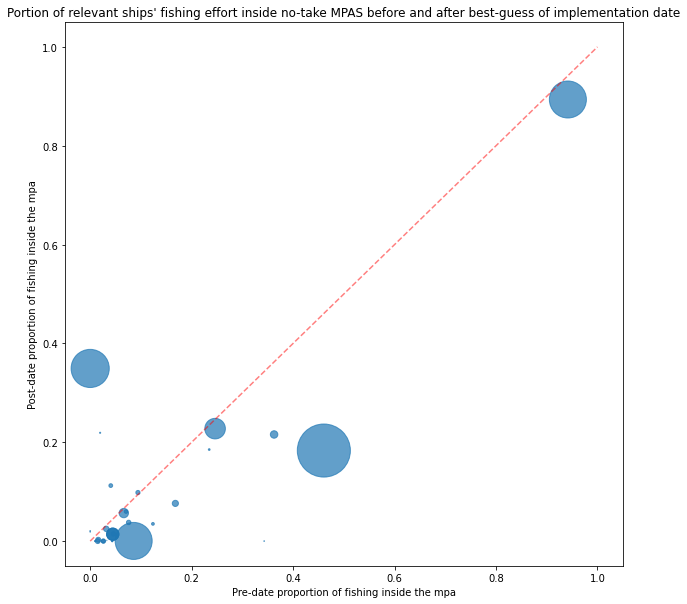

In [16]:
points = summed_tables[(summed_tables['in_pre'] > 0) | summed_tables['in_post'] > 0]
sizes = ((points['in_pre'] + points['in_post']))/100
#sizes = points['mmsi'] * 5
plt.figure(figsize=(10, 10))
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), '--', c='red', alpha=0.5)
plt.xlabel('Pre-date proportion of fishing inside the mpa')
plt.ylabel('Post-date proportion of fishing inside the mpa')
plt.title('Portion of relevant ships\' fishing effort inside no-take MPAS before and after best-guess of implementation date')

plt.scatter(points['in_pre_p'], points['in_post_p'], s=sizes, alpha=0.7)

This shows proportion of fishing effort of relevant ships inside 30 MPAs before and after their implementation, scaled by the amount of total fishing effort seen inside those areas (between 2012 and 2020).

Of some 165 MPAs that fit the criteria of being 'no-take' and fully implemented with either an implementation date or, if that is not available, a status year between 2012 and 2020, only these 30 MPAs actually had any fishing effort inside them at all.

Relevent ships are unique mmsi that spent any fishing effort inside the MPA between 2012 and 2020 according to the GFW data.

In [17]:
no_take.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1056 entries, 185 to 20932
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   mpa_id      1056 non-null   int64   
 1   wdpa_id     1056 non-null   int64   
 2   wdpa_pid    851 non-null    object  
 3   name        1056 non-null   object  
 4   country     1056 non-null   object  
 5   sovereign   1056 non-null   object  
 6   designatio  1056 non-null   object  
 7   designat_1  1048 non-null   object  
 8   designat_2  1010 non-null   object  
 9   iucn_categ  871 non-null    object  
 10  status      1056 non-null   object  
 11  status_yea  1056 non-null   int64   
 12  is_mpa      1056 non-null   int64   
 13  implemente  1056 non-null   int64   
 14  implementa  71 non-null     object  
 15  no_take     1056 non-null   object  
 16  no_take_ar  1056 non-null   float64 
 17  rep_m_area  1056 non-null   float64 
 18  calc_m_are  1056 non-null   float64 


In [18]:
no_take = mpas[(mpas['no_take']=='All') & (mpas['implemente'])]
all_no_take = []
of_interest = [
    (None, 555512002, 'Phoenix Island Protected Area', '2015-01-01')
]
# for i, row in no_take[no_take['status_yea'] > 2012].iterrows():
for i, row in no_take.iterrows():
    date = row['implementa']
    if date is None:
        date = str(row['status_yea'])
    of_interest.append(
        (row['mpa_id'], row['wdpa_id'], row['name'], date)
    )


In [19]:
no_take_tables = pandas.DataFrame()
no_take_summed_tables = pandas.DataFrame()
j = 0
for i, row in no_take.iterrows():
    name = row['name']
    mpa_id = row['mpa_id']
    wdpa_id = row['wdpa_id']
    date = row['implementa']
    if date is None:
        date = str(row['status_yea'])
    if date is None:
        print(f'no date for {name}, skipping')
        continue
    j += 1
    print(f'\r{j}/{no_take.shape[0]} {mpa_id} {wdpa_id} {name} {date}                           ', end='')
    mpa = None
    if wdpa_id:
        mpa = mpas[mpas['wdpa_id'] == wdpa_id].dissolve(by='wdpa_id')
    elif mpa_id:
        mpa = mpas[mpas['mpa_id'] == mpa_id].dissolve(by='mpa_id')
    else:
        print(f'no id for {name}, skipping')
        continue
    
    returned = util.analyze_mpa(geopoints_sampled, points_by_year, mpa, date, verbose=False, plot_pre_post=False)
    if returned is not None:
        table = returned
        table.insert(0, 'name', name)
        table.insert(1, 'date', date)
        table.insert(2, 'wdpa_id', wdpa_id)
        table.insert(3, 'mpa_id', mpa_id)
        no_take_tables = no_take_tables.append(table)
        
        summed = table.groupby('name').aggregate({
            'name': 'first',
            'wdpa_id': 'first',
            'mpa_id': 'first',
            'date': 'first',
            'mmsi': 'count',
            'in_pre': 'sum',
            'out_pre': 'sum',
            'in_post': 'sum',
            'out_post': 'sum'})
        no_take_summed_tables = no_take_summed_tables.append(summed)
    else:
        no_take_summed_tables = no_take_summed_tables.append(
            {'name': mpa.iloc[0]['name'], 'wdpa_id': wdpa_id, 'mpa_id': mpa_id, 'date': date}
            , ignore_index=True)

1056/1056 1 1 Diamond Reef and Salt Fish Tail Reef 1973                                                                                             in 1972 1972                                       

In [20]:
no_take_summed_tables.sort_values('mmsi', ascending=False)

,name,wdpa_id,mpa_id,date,mmsi,in_pre,out_pre,in_post,out_post
299,Phoenix Islands Protected Area,555512002.0,7705427.0,2010,138.0,0.0000,0.0000,137184.1583,4.252825e+06
753,Phoenix Islands,309888.0,4395.0,2006,135.0,0.0000,0.0000,134882.6121,4.192880e+06
275,Palau,555622118.0,68807606.0,2020-01-01,86.0,259083.4308,303384.0940,22833.6212,1.017835e+05
345,Great Barrier Reef - Preservation Zone,2628.0,7700301.0,2004,55.0,0.0000,0.0000,81825.8984,1.776301e+05
213,Great Barrier Reef - Scientific Research Zone,2628.0,68808375.0,2004,55.0,0.0000,0.0000,81825.8984,1.776301e+05
212,Great Barrier Reef - Marine National Park Zone,2628.0,68808376.0,2004,55.0,0.0000,0.0000,81825.8984,1.776301e+05
215,South Georgia and South Sandwich Islands [No-T...,555547601.0,68808365.0,2012,25.0,0.0000,0.0000,145640.0640,2.712474e+05
166,Coral Sea - National Park Zone,555556875.0,68808920.0,2018-07-01,18.0,27755.7379,84960.4152,14564.0410,4.944051e+04
553,Ross Sea Region [General Protection Zone (i) R...,555624810.0,9047.0,2017-12-01,17.0,12802.7103,274971.2486,2108.6459,1.495790e+05
95,Ross Sea Region [General Protection Zone (iii)...,555624810.0,68813308.0,2017-12-01,17.0,12802.7103,274971.2486,2108.6459,1.495790e+05


In [21]:
# html_table_blue_light = pretty_html_table.build_table(no_take_summed_tables.sort_values('mmsi', ascending=False), 'blue_light')

# Save to html file
# with open('2022/winter/week06/in_out_effort_all_no_take.html', 'w') as f:
#    f.write(html_table_blue_light)

## Trying to analyze the individual ships, etc. of the interesting ones

In [36]:
test_row = mpas_with_effort_in_pre.iloc[1, :]

name         Niue Moana Mahu Marine Protected Area
wdpa_id                                  555705568
mpa_id                                    68819192
date                                          2020
mmsi                                          10.0
in_pre                                   2409.9022
out_pre                                149433.5107
in_post                                   111.0827
out_post                                41784.4454
in_pre_p                                  0.015871
in_post_p                                 0.002651
Name: 5, dtype: object

In [37]:
mpas_with_effort_in_pre = summed_tables[(summed_tables['in_pre'] > 0)]
test_row = mpas_with_effort_in_pre.iloc[1, :]




In [41]:
test_row = mpas_with_effort_in_pre.iloc[1, :]
mpa_id = test_row['mpa_id']
wdpa_id = test_row['wdpa_id']



mpa = None
if wdpa_id is not None:
    mpa = mpas[mpas['wdpa_id'] == wdpa_id]
else:
    mpa = mpas[mpas['mpa_id'] == mpa_id]
if mpa is None:
    print("mpa can't be found")
    #return

points_of_mpa_ships = util.points_of_interest(
    geopoints_sampled, points_by_year, mpa, date)
if points_of_mpa_ships is None:
    print('no points')
    #return

geopoints_ = util.convert_to_geo(points_of_mpa_ships, box=True)
geopoints_['pre'] = geopoints_['date'] < date
# fastest way to do this is just this whole join:
geopoints_['in_mpa'] = ~geopandas.sjoin(
    geopoints_, mpa[['geometry']], how='left', predicate='within')['index_right'].isnull()



In [51]:
def plot_effort(effort, window=30):
    x = effort['date']
    y = effort['fishing_hours']
    z = np.zeros(len(y) - window)
    for i in range(len(y) - window):
        z[i] = sum(y[i:i+window])/window
    plt.plot(x[:-window], z)

In [68]:
for mmsi in set(geopoints_['mmsi']):
    in_points = geopoints_[(geopoints_['mmsi'] == mmsi) & geopoints_['in_mpa']].sort_values('date', ascending=True)
    print(in_points.shape)
    out_points = geopoints_[(geopoints_['mmsi'] == mmsi) & ~geopoints_['in_mpa']].sort_values('date', ascending=True)
    print(out_points.shape)
    plot_effort(in_points, window=365)
    plot_effort(out_points, window=365)
    break

(167, 8)
(14952, 8)


ValueError: negative dimensions are not allowed